# INFO

Requirements:
- Data files: 
    - SEVN data files: the SEVN tracks are already included in the repository in the folder SEVN. The tracks have been generated with the Iorio22 SEVN release: [https://gitlab.com/sevncodes/sevn/-/releases/iorio22](https://gitlab.com/sevncodes/sevn/-/releases/iorio22)
    - POSYDON data files: the posydon tracks can be downloaded from the Zedonodo repository    [https://doi.org/10.5281/zenodo.6655751](https://doi.org/10.5281/zenodo.6655751) (we use the Version 3), and the Posydon code from the branch development updated to the commit 80231b4  (https://github.com/POSYDON-code/POSYDON/tree/80231b4a64cc4bb3bf74f373c4b320edf19ac4f9)
    - COMBINE data files: the combine tracks has been kindly provided by Matthias Kruckow (private communication)
- Python 3.9 or newer
- modules: pandas, numpy, matplotlib, posydon


Data structure:

- SEVN_simulations: 
    A folder labelled SEVN with two subfolders:
        - mist: containing the SSE output obtained   with the MIST tables
        - parsec05: containing the SSE output obtained   with the MIST tables with the PARSEC (tables with ov=0.5) tables
- POSYDON tracks
    A folder labelled  posydon_tracks with a subfolder: 
        - single_HMS: containg the file grid_0.0142.h5 containing the stellar tracks 
- COMBINE tracks
    A folder labelled as Combine-BEC

In [23]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from posydon.interpolation import GRIDInterpolator


import matplotlib as mpl
label_size =18
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
#mpl.rcParams['mathtext.default']='regular'
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['contour.negative_linestyle'] = 'solid'
mpl.rcParams['axes.facecolor'] = 'white'
import warnings
warnings.filterwarnings('ignore')

G = 3.925125598496094e8
Msun_cgs = 1.988409870698051e+33
Rsun_cgs = 6.95700e10
yr_cgs = 3.1557600e7
K = Msun_cgs*Rsun_cgs*Rsun_cgs/(yr_cgs*yr_cgs)
    

def load_COMBINE(M,Z):
    
    Mlist=(15,20,100)
    Zlist=(0.0088,0.0002)
    
    if not M in Mlist: raise ValueError(f"Mass {M} not in Mlist {Mlist}")
    elif not Z in Zlist: raise ValueError(f"Z {Z} not in Zlist {Zlist}")
        
    root="Combine-BEC"
    
    
    if Z==0.0088: Zs="mw"
    elif Z==0.0002: Zs="IZw18"
        
    if M<100: Ms=f"{int(M)}_0"
    else: Ms=f"{int(M)}"
    
    filename=f"{Ms}-{Zs}.tab"
    
    colname=("Mass","Worldtime", "Radius", "MHE", "Luminosity", "Temperature", "lambdaG", "lambda", "MCO", "cf","He4c")
    df=pd.read_csv(root+"/"+filename,header=None,sep="\s+",names=colname)
    
    df["Worldtime"]=df["Worldtime"]*1e-6
    df["Luminosity"]=10**df["Luminosity"]
    df["Temperature"]=10**df["Temperature"]
    df["Ebind"]=G*K*df.Mass*(df.Mass-df.MHE)/(df.Radius*df["lambda"])
    rowTMS=int(df["Mass"].values[-1]*-1)
    
    
    return df


def load_POSYDON(M,Z):
    
    if Z!=0.0142: raise ValueError("Posydon tracks only available for Z=0.014")
    Star=GRIDInterpolator("posydon_tracks/single_HMS/grid_0.0142.h5")
    
    dfdic={"Worldtime":Star.get("age",M)*1e-6,
          "Mass":Star.get("mass",M),
          "Luminosity":10**Star.get("log_L",M),
          "Temperature":10**Star.get("log_Teff",M),
          "lambda":Star.get("lambda_CE_10cent",M),
          "MHE":Star.get("he_core_mass",M),
          "Radius":10**Star.get("log_R",M),
          "Ebind":np.abs(Star.get("envelope_binding_energy",M)),
          "He4c":Star.get("center_he4",M)}
    
    
    return pd.DataFrame(dfdic)


def load_SEVN(M,Z,tracks="parsec"):
    
    Mlist=(15,20,85,100,120)
    Zlist=(0.0088,0.0142,0.0002,0.02)
    
    if not M in Mlist: raise ValueError(f"Mass {M} not in Mlist {Mlist}")
    elif not Z in Zlist: raise ValueError(f"Z {Z} not in Zlist {Zlist}")
        
        
    if tracks=="parsec": root="SEVN/parsec05"
    elif tracks=="mist": root="SEVN/mist"
    else: raise ValueError(f"Tracks option {tracks} unknown")
    
    
    df=pd.read_csv(f"{root}/output_0.csv")
    idx=(df.Zams==M)&(df.Zmet==Z)
    ID=df[idx&(df.Worldtime==0)].ID.values[0]
    idx = (df.Phase<7)&(df.ID==ID)
    
    
    df["Ebind"] = G*K*np.abs(df.Ebind)
    df["Ebind"][df.PhaseBSE>=7] = 0
  
    
    return df[idx]

def plot_track(df,ax,opt_dict,tracks=None):
    
    if tracks is not None: ips=find_important_points(df,tracks=tracks)[0]
    else: ips={}
    
    for ip in ips:
        ax.scatter(np.log10(ips[ip][0]),np.log10(ips[ip][1]),marker=ips[ip][2],zorder=1000,c=opt_dict["c"],
                  ec="k",s=200)
    
    ax.plot(np.log10(df.Temperature),np.log10(df.Luminosity),**opt_dict)
    
    return
    
def plot_Ebind(df,ax,opt_dict,tracks=None):
    
    
    if tracks is not None: ips=find_important_points(df,tracks=tracks)[1]
    else: ips={}
        

    for ip in ips:
        ax.scatter(ips[ip][0],ips[ip][1],marker=ips[ip][2],zorder=1000,c=opt_dict["c"],
                  ec="k",s=200)
    
    idx=df.MHE>0.1
    
    #ax.plot(time[idx],df.Ebind[idx],**opt_dict)
    #ax.plot(df.Worldtime/np.max(df.Worldtime),df.Ebind,**opt_dict)
    ax.plot(df.Worldtime[idx],df.Ebind[idx],**opt_dict)
    
    return 
   

def plot_radii(R,ax,htext=5.65,Rlabel=None,dx=0.01):
    
    T0=5778
    
    L = lambda T,R: np.log10(R*R*(T/T0)**4)
    Tr = lambda ll,R: np.log10(T0*((ll/R**2)**(1/4)))*1.001
    
    ylim=ax.get_ylim()
    xlim=ax.get_xlim()

    if Rlabel is None: Rlabel=R

    T=np.logspace(np.log10(1e2),np.log10(1e7))
    for rr in R:
        LL=L(T,rr)
        ax.plot(np.log10(T),LL,c="gray",zorder=-10,ls="dotted")
        htext=htext+dx
        
        #idx_inside=(LL>ylim[0])&(LL<ylim[1])&(np.log10(T)>xlim[0])&(np.log10(T)<xlim[1])

        if rr in Rlabel:
            ax.text(Tr(10**htext,rr),htext,f"{rr} \nR$_\odot$",fontsize=label_size-4,color="gray")
    
    return 

def find_important_points(df,tracks="parsec"):
    
    if tracks=="parsec" or tracks=="mist":
        Tv=df.Temperature.values
        Lv=df.Luminosity.values
        Ev=df.Ebind.values 
        Av=df.Worldtime.values

        #Starts 
        ip1={"start":(Tv[0],Lv[0],"o")}
        ip2={"start":(Av[0],Ev[0],"o")}
        #HecoreBurning
        idx=df.Phase==4
        ip1["CHeB"]=(Tv[idx][0],Lv[idx][0],"X")
        ip2["CHeB"]=(Av[idx][0],Ev[idx][0],"X")
    elif tracks=="posydon":
        Tv=df.Temperature.values
        Lv=df.Luminosity.values
        Ev=df.Ebind.values 
        Av=df.Worldtime.values
        He4cv=df.He4c 
        
        #Starts 
        ip1={"start":(Tv[0],Lv[0],"o")}
        ip2={"start":(Av[0],Ev[0],"o")}
        #HecoreBurning
        argmax=np.argmax(He4cv)
        Tvr=Tv[argmax:]
        Lvr=Lv[argmax:]
        Evr=Ev[argmax:]
        Avr=Av[argmax:]
        He4cvr=He4cv[argmax:]
        
        idx=He4cvr<0.99*np.max(He4cvr)
        ip1["CHeB"]=(Tvr[idx][0],Lvr[idx][0],"X")
        ip2["CHeB"]=(Avr[idx][0],Evr[idx][0],"X")
    elif tracks=="combine":
        Tv=df.Temperature.values
        Lv=df.Luminosity.values
        Ev=df.Ebind.values 
        Av=df.Worldtime.values
        He4cv=df.He4c 
        
        #Starts 
        ip1={"start":(Tv[0],Lv[0],"o")}
        ip2={"start":(Av[0],Ev[0],"o")}
        #HecoreBurning
        argmax=np.argmax(He4cv)
        Tvr=Tv[argmax:]
        Lvr=Lv[argmax:]
        Evr=Ev[argmax:]
        Avr=Av[argmax:]
        He4cvr=He4cv[argmax:]
        
        idx=He4cvr<0.99*np.max(He4cvr)
        if np.sum(idx)>0:
            ip1["CHeB"]=(Tvr[idx][0],Lvr[idx][0],"X")
            ip2["CHeB"]=(Avr[idx][0],Evr[idx][0],"X")
        
    else:
        ip1={}
        ip2={}
    
    return ip1,ip2

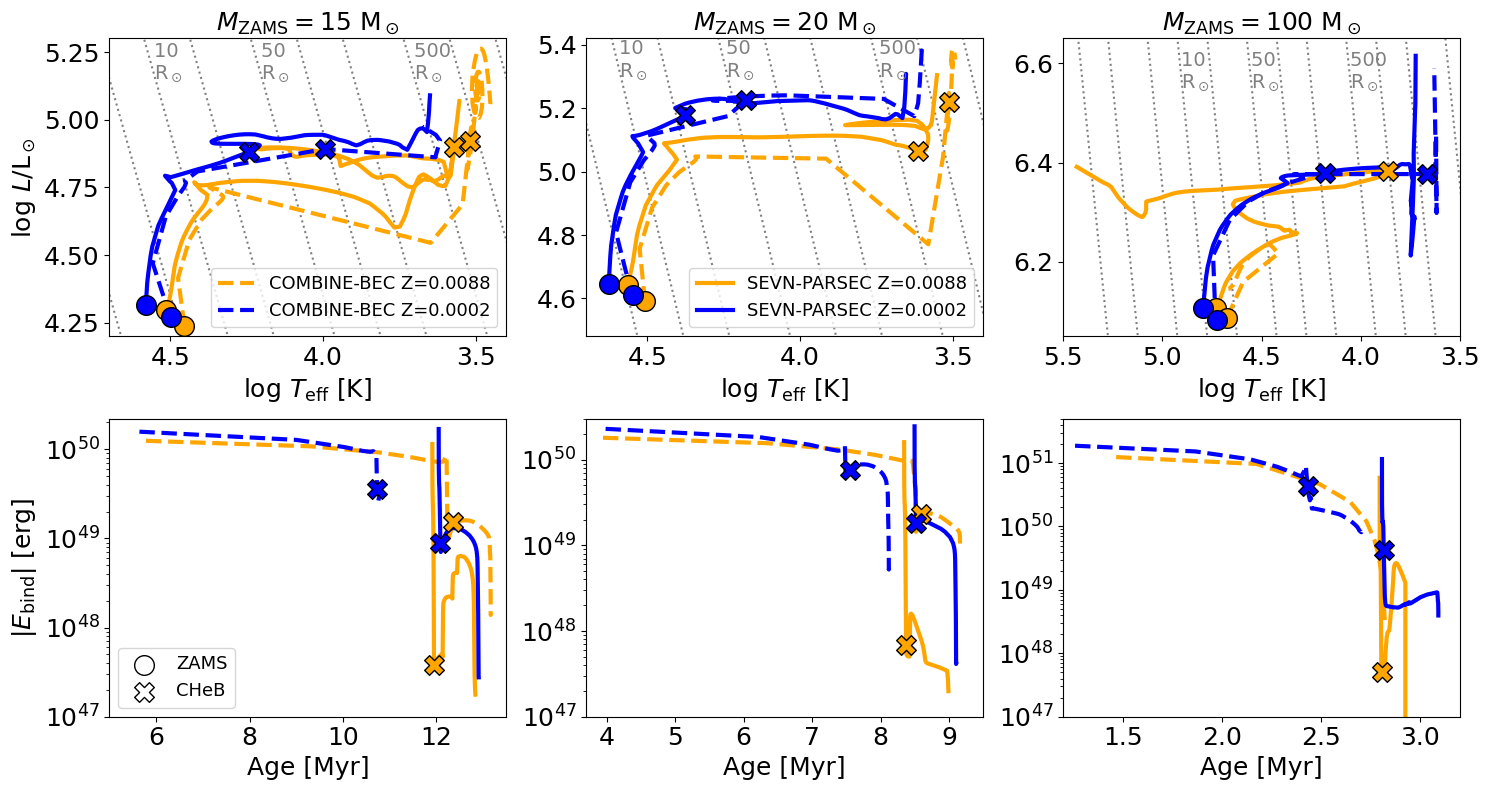

In [32]:
#COMBINE
fig,axl=plt.subplots(2,3,figsize=(15,8))


Ml=(15,20,100)
Zl=(0.0088,0.0002)

clist=("orange","blue")


for i,M in enumerate(Ml): 
    for j,Z in enumerate(Zl):
        
        dfco=load_COMBINE(M,Z)
        dfpa=load_SEVN(M,Z,"parsec")
        dfme=load_SEVN(M,Z,"mist")
        
        axpop   = axl[0,i]
        axpop.set_title(f"$M_\mathrm{{ZAMS}}={M} \ \mathrm{{M}}_\odot$",fontsize=label_size)
        axebind = axl[1,i]
        
        labelco=None
        labelpa=None
        if i==0: 
            labelco=f"COMBINE-BEC Z={Z}"
            if j==0:
                axebind.scatter([0,],[0,],s=200, marker="o",ec="k",c="white",label="ZAMS")
                axebind.scatter([0,],[0,],s=200, marker="X",ec="k",c="white",label="CHeB")
        elif i==1:
            labelpa=f"SEVN-PARSEC Z={Z}"

            
        plot_track(dfpa,ax=axpop,opt_dict={"c":clist[j],"lw":3,"label":labelpa},tracks="parsec")
        plot_track(dfco,ax=axpop,opt_dict={"ls":"dashed","c":clist[j],"lw":3,"label":labelco},tracks="combine")
        
        plot_Ebind(dfpa,ax=axebind,opt_dict={"c":clist[j],"lw":3},tracks="parsec")
        plot_Ebind(dfco,ax=axebind,opt_dict={"ls":"dashed","c":clist[j],"lw":3},tracks="combine")

        

for j,ax in enumerate(axl[0,:]):
    if j==0: ax.set_ylabel("log $L$/L$_\odot$",fontsize=label_size)
    ax.set_xlabel("log $T_\mathrm{eff}$ [K]",fontsize=label_size)
        
        
for j,ax in enumerate(axl[1,:]):
    
    if j==0: ax.set_ylabel("|$E_\mathrm{bind}$| [erg]",fontsize=label_size)
    ax.set_xlabel("Age [Myr]",fontsize=label_size)
    
    ax.set_yscale("log")
    locmax = mpl.ticker.LogLocator(base=10.0,numticks=12)
    locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_major_locator(locmax)
    
axl[0,0].legend(loc="lower right",fontsize=13)    
axl[0,1].legend(loc="lower right",fontsize=13)  
axl[1,0].legend(loc="lower left",fontsize=13)  

Rlist=np.array([np.array([1,2,5])*n for n in (1,10,100,1000)]).flatten()
    
plot_radii(Rlist,axl[0,0],htext=5.15,Rlabel=[10,50,500],dx=0.00)
axl[0,0].set_xlim(4.7,3.4)
axl[0,0].set_ylim(4.2,5.3)


plot_radii(Rlist,axl[0,1],htext=5.3,Rlabel=[10,50,500],dx=0.0)
axl[0,1].set_xlim(4.7,3.4)
axl[0,1].set_ylim(4.48,5.42)


plot_radii(Rlist,axl[0,2],htext=6.55,Rlabel=[10,50,500],dx=0.0)
axl[0,2].set_xlim(5.5,3.5)
axl[0,2].set_ylim(6.05,6.65)

axl[1,0].set_xlim(5,13.5)
axl[1,1].set_xticks([5,6,7,8,9,10,11,12,13])
axl[1,0].set_ylim(1e47,2.2e50)
axl[1,1].set_xlim(3.7,9.5)
axl[1,1].set_xticks([4,5,6,7,8,9])
axl[1,1].set_ylim(1e47,3e50)
axl[1,2].set_xlim(1.2,3.2)
axl[1,2].set_ylim(1e47,5e51)


fig.tight_layout()
plt.savefig("compare_combine.pdf")
plt.show()

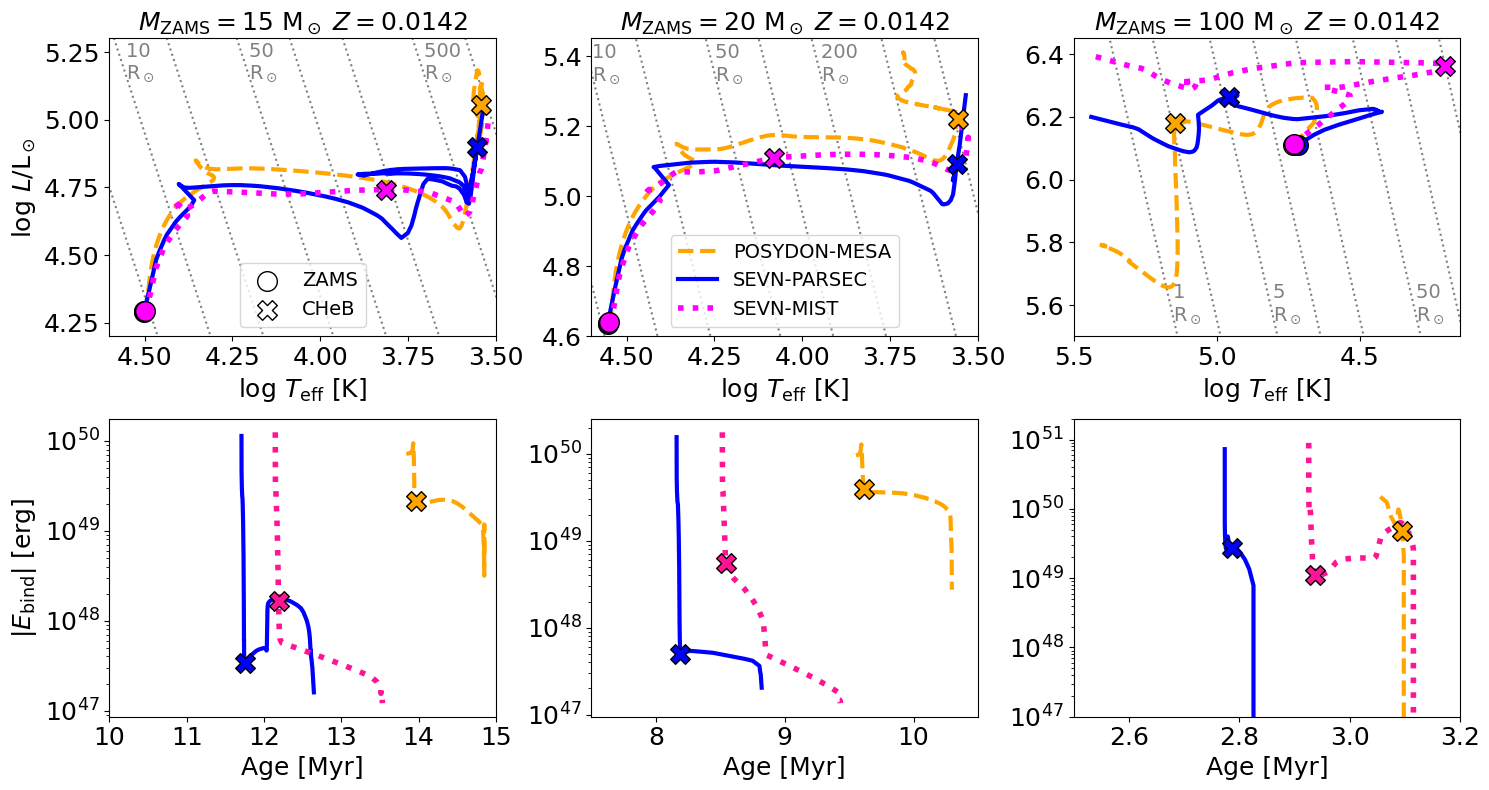

In [4]:
#POSYDON-MIST
fig,axl=plt.subplots(2,3,figsize=(15,8))
Ml=(15,20,100)
Zl=(0.0142,)



for i,M in enumerate(Ml): 
    for j,Z in enumerate(Zl):
        
        dfco=load_POSYDON(M,Z)
        dfpa=load_SEVN(M,Z,"parsec")
        dfme=load_SEVN(M,Z,"mist")
        
        axpop   = axl[0,i]
        axpop.set_title(f"$M_\mathrm{{ZAMS}}={M} \ \mathrm{{M}}_\odot$ $Z={Z}$",fontsize=label_size)
        axebind = axl[1,i]
        
        labelpa=None
        labelco=None
        labelm=None
        
        if i==0 and j==0:
            axpop.scatter([0,],[0,],s=200, marker="o",ec="k",c="white",label="ZAMS")
            axpop.scatter([0,],[0,],s=200, marker="X",ec="k",c="white",label="CHeB")
        
        if i==1:
            labelpa=f"SEVN-PARSEC"
            labelm=f"SEVN-MIST"
            labelco=f"POSYDON-MESA" 
            

        plot_track(dfco,ax=axpop,opt_dict={"ls":"dashed","c":"orange","lw":3,"label":labelco},tracks="posydon")
        plot_track(dfpa,ax=axpop,opt_dict={"c":"blue","lw":3,"label":labelpa},tracks="parsec")
        plot_track(dfme,ax=axpop,opt_dict={"ls":"dotted","c":"magenta","lw":4,"label":labelm},tracks="mist")
        
        plot_Ebind(dfco,ax=axebind,opt_dict={"ls":"dashed","c":"orange","lw":3},tracks="posydon")
        plot_Ebind(dfpa,ax=axebind,opt_dict={"c":"blue","lw":3},tracks="parsec")
        plot_Ebind(dfme,ax=axebind,opt_dict={"ls":"dotted","c":"deeppink","lw":4},tracks="mist")
        
        

for j,ax in enumerate(axl[0,:]):
    if j==0: ax.set_ylabel("log $L$/L$_\odot$",fontsize=label_size)
    ax.set_xlabel("log $T_\mathrm{eff}$ [K]",fontsize=label_size)
        
        
for j,ax in enumerate(axl[1,:]):
    
    if j==0: ax.set_ylabel("|$E_\mathrm{bind}$| [erg]",fontsize=label_size)
    ax.set_xlabel("Age [Myr]",fontsize=label_size)

    
    ax.set_yscale("log")
    locmax = mpl.ticker.LogLocator(base=10.0,numticks=12)
    locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_major_locator(locmax)
       

axl[0,0].legend(fontsize=14) 
axl[0,1].legend(fontsize=14)        

plot_radii(Rlist,axl[0,0],htext=5.15,Rlabel=[10,50,500],dx=0.00)
axl[0,0].set_xlim(4.6,3.5)
axl[0,0].set_ylim(4.2,5.3)
        
plot_radii(Rlist,axl[0,1],htext=5.33,Rlabel=[10,50,200],dx=0.00)
axl[0,1].set_xlim(4.6,3.5)
axl[0,1].set_ylim(4.6,5.45)

plot_radii(Rlist,axl[0,2],htext=5.55,Rlabel=[1,5,50],dx=0.00)
axl[0,2].set_xlim(5.5,4.15)
axl[0,2].set_ylim(5.5,6.45)

axl[1,0].set_xlim(10,15)
axl[1,1].set_xlim(7.5,10.5)
axl[1,2].set_xlim(2.5,3.2)
axl[1,2].set_ylim(1e47,2e51)

fig.tight_layout()
plt.savefig("compare_posydon.pdf")
plt.show()

In [21]:
dfco=load_COMBINE(M=100,Z=0.0002)

In [22]:
dfco

Mass  Worldtime       Radius        MHE    Luminosity   Temperature  \
0   100.000000   0.000000    13.052376   0.000000  1.213339e+06  53151.878685   
1   100.000000   0.003169    12.669132   0.000094  1.218385e+06  54005.824045   
2    99.641516   1.260144    13.862502  27.873877  1.633733e+06  55557.457942   
3    99.248825   1.865576    22.233072  43.636602  1.927564e+06  45721.487337   
4    98.982223   2.143098    35.410331  51.854511  2.096105e+06  36996.117489   
5    98.867925   2.277994    53.258697  56.123403  2.191138e+06  30502.824276   
6    98.830897   2.346106    71.473366  58.222068  2.239076e+06  26473.600201   
7    98.800026   2.381197    83.421359  59.388882  2.264689e+06  24574.314257   
8    98.763939   2.399354    89.967392  60.040225  2.280039e+06  23703.413258   
9    98.714563   2.420091   150.090019  60.560683  2.349275e+06  18489.509036   
10   98.674500   2.422640   108.751016  60.597287  2.381569e+06  21795.511686   
11   98.441597   2.431002  2416.611954  60.485100  2.382377e+06   4623.990367   
12   98.427719   2.431408  2542.891769  60.484467  2.364403e+06   4499.190786   
13   98.416544   2.431728  2615.787770  60.485370  2.355179e+06   4431.723311   
14   98.404500   2.432066  2675.268668  60.484061  2.364839e+06   4386.667793   
15   98.387679   2.432525  2733.193733  60.485108  2.386799e+06   4349.975526   
16   98.359488   2.433274  2781.206414  60.486566  2.406318e+06   4321.054902   
17   98.317989   2.434354  2822.565194  60.487482  2.422375e+06   4296.415338   
18   98.251307   2.436059  2855.012196  60.487957  2.434516e+06   4277.276008   
19   98.129292   2.439135  2881.711044  60.476218  2.444865e+06   4261.926148   
20   97.966083   2.443234  2892.007621  60.474535  2.436061e+06   4250.501262   
21   97.786434   2.447781  2882.940803  59.689999  2.404755e+06   4243.436612   
22   97.671840   2.450763  2847.126758  59.690159  2.333347e+06   4237.980399   
23   97.624996   2.452040  2832.090179  59.689251  2.290600e+06   4229.618200   
24   97.594605   2.452875  2853.625184  59.688075  2.303008e+06   4219.327918   
25   96.917360   2.469349  2960.210135  59.667005  2.476228e+06   4218.463215   
26   95.817951   2.495667  2989.869936  59.679463  2.511484e+06   4212.349132   
27   94.814647   2.519154  3015.046045  59.688068  2.543491e+06   4208.026436   
28   93.913549   2.539834  3038.677047  59.694367  2.572585e+06   4203.571136   
29   93.094963   2.558295  3058.478144  59.699244  2.598524e+06   4200.460452   
30   92.344499   2.574962  3076.408012  59.703235  2.621926e+06   4197.600092   
31   91.666444   2.589816  3090.713507  59.706688  2.642566e+06   4196.093460   
32   91.043578   2.603313  3105.274797  59.709408  2.660188e+06   4193.204187   
33   90.488748   2.615223  3116.573288  59.711598  2.675832e+06   4191.736032   
34   89.979497   2.626057  3120.914032  59.713376  2.683430e+06   4191.790527   
35   89.521816   2.635715  3134.793662  59.714927  2.702031e+06   4189.730085   
36   89.113216   2.644280  3142.689272  59.716275  2.714142e+06   4189.144364   
37   88.753704   2.651765  3150.428877  59.717421  2.725606e+06   4188.406500   
38   88.434438   2.658374  3155.128945  59.718449  2.734474e+06   4188.686048   
39   88.148798   2.664255  3164.306844  59.719438  2.745189e+06   4186.699213   
40   87.901933   2.669310  3166.818085  59.720308  2.750363e+06   4187.008501   
41   87.684943   2.673735  3172.083896  59.720214  2.759807e+06   4187.118531   
42   87.495780   2.677576  3176.715156  59.720918  2.766169e+06   4186.474357   
43   87.330163   2.680926  3182.143939  59.721534  2.774164e+06   4185.923995   
44   87.188165   2.683789  3187.688176  59.722068  2.781670e+06   4185.105188   
45   86.958359   2.688405  3186.417182  59.721138  2.782452e+06   4186.233999   
46   86.868164   2.690211  3193.226157  59.721514  2.792495e+06   4185.536544   
47   86.790676   2.691759  3192.736134  59.721850  2.790885e+06   4185.254441   
48   86.263603   2.702104  3232.181669  5